# IMPORTING LIBRARIES

In [1]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time
import tensorflow_probability as tfp

# IMPORTING MNIST DATA

In [2]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# VISUALIZING THE DATA

In [3]:
X_train.shape

(60000, 28, 28)

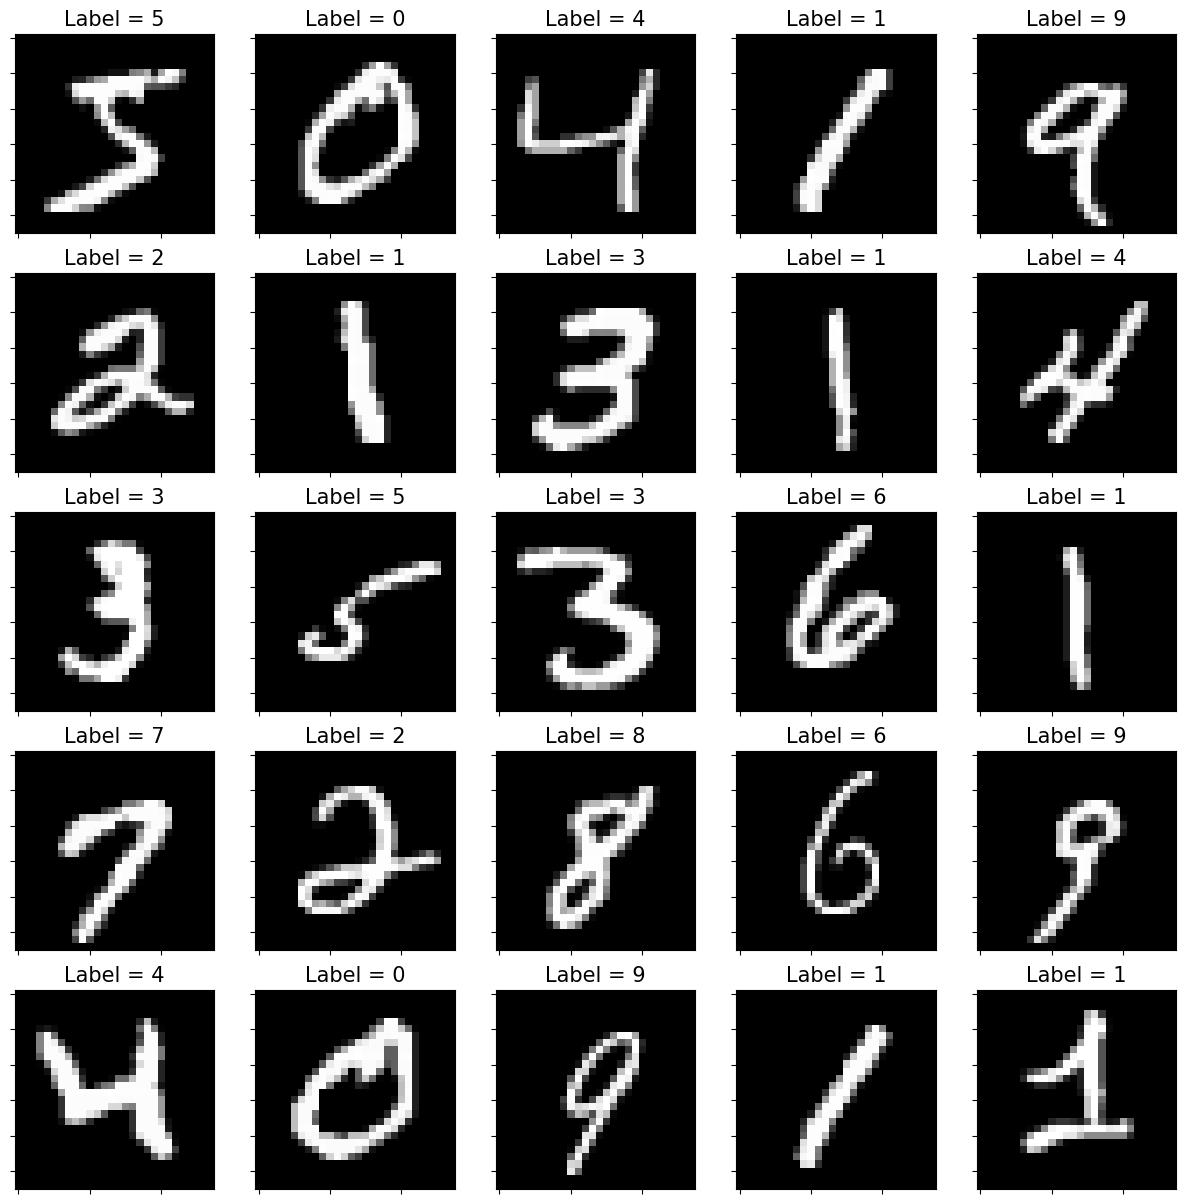

In [4]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(15,15))
row =0
col = 0
for i in range(25):
    if col in [4,9,14,19]:
        axes[row][col].imshow(X_train[i],cmap="gray")
        axes[row][col].set_title("Label = "+str(y_train[i]),fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        row+=1
        col = 0
    else:
        axes[row][col].imshow(X_train[i],cmap="gray")
        axes[row][col].set_title("Label = "+str(y_train[i]),fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
fig.show()

# SHUFFLING AND MAKING DATASET

In [5]:
def make_dataset(X_train):
    images = X_train.reshape((-1,28,28,1))/255
    return np.where(images>0.5,1.0,0.0).astype(np.float32)

In [6]:
train_images = make_dataset(X_train)
test_images = make_dataset(X_test)

In [7]:
def make_tensor_data(data,shuffle_size,batch_size):
    return tf.data.Dataset.from_tensor_slices(data).shuffle(shuffle_size).batch(batch_size)

In [8]:
train_dataset = make_tensor_data(train_images,train_images.shape[0],32)
test_dataset = make_tensor_data(test_images,test_images.shape[0],32)

# MODEL BUILDING

## ENCODER BUILDING

In [9]:
class encoder:
    def __init__(self,latent_dim,img_shape,conv_info = {}):
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(input_shape = img_shape))
        if conv_info == []:
            for filters,kernel in  {32:3,64:3}.items():
                self.encoder.add(tf.keras.layers.Conv2D(filters,kernel,strides=(2,2),activation="relu"))
        else:
            for filters,kernel in conv_info.items():
                self.encoder.add(tf.keras.layers.Conv2D(filters,kernel,strides=(2,2),activation="relu"))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(self.latent_dim+self.latent_dim))

In [45]:
encoder1 = encoder(7,(28,28,1)).encoder
encoder1.compile(loss="sparse_categorical_crossentropy",optimizer="adam")
encoder1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 14)                10990     
                                                                 
Total params: 10990 (42.93 KB)
Trainable params: 10990 (42.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## DECODER MODEL

In [43]:
class decoder:
    def __init__(self,latent_dim):
        self.latent_dim = latent_dim
        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.layers.InputLayer(input_shape = (latent_dim,)))
        self.decoder.add(tf.keras.layers.Dense(7*7*32,activation="relu"))
        self.decoder.add(tf.keras.layers.Reshape(target_shape = (7,7,32)))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(64,3,strides = 2,activation="relu",padding="same"))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(32,3,strides = 2,activation="relu",padding="same"))
        self.decoder.add(tf.keras.layers.Conv2DTranspose(1,3,strides = 1,padding="same"))

In [44]:
decoder1 = decoder(7).decoder
decoder1.compile(loss="sparse_categorical_crossentropy",optimizer="adam")
decoder1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1568)              12544     
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose_25 (Conv2  (None, 14, 14, 64)        18496     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_26 (Conv2  (None, 28, 28, 32)        18464     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_27 (Conv2  (None, 28, 28, 1)         289       
 DTranspose)                                                     
                                                     

## COMBINING THE ARCHITECTURES TO FORM THE FINAL CVAR

In [13]:
class CVAR(tf.keras.Model):
    def __init__(self,latent_dim,image_shape):
        super(CVAR,self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder(latent_dim,image_shape).encoder
        self.decoder = decoder(latent_dim).decoder
    @tf.function
    def sample(self,eps = None):
        if eps==None:
            eps = tf.random.normal(shape=(100,self.latent_dim))
        return self.decode(eps,apply_sigmoid = True)
    def encode(self,x):
        mean,logvar = tf.split(self.encoder(x),num_or_size_splits=2,axis=1)
        return mean,logvar
    def reparameterize(self,mean,logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar*.5)+mean
    def decode(self,x,apply_sigmoid = False):
        logits = self.decoder(x)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# CREATING LOSS FUNCTINS FOR THE MODEL

In [93]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [94]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [95]:
@tf.function
def train_step(model,x,optimizer):
    with tf.GradientTape() as Tape:
        loss = compute_loss(model,x)
    gradients = Tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

# TRAINING THE MODEL

In [96]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model = CVAR(2,(28,28,1))

In [97]:
def predict(model,test_sample):
    mean,logvar = model.encode(test_sample)
    z = model.reparameterize(mean,logvar)
    predictions = model.sample(z)
    return predictions

In [98]:
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:16,:,:,:]

In [99]:
predictions = predict(test_sample=test_sample,model=model)
predictions.shape

TensorShape([16, 28, 28, 1])

In [100]:
def fit(model,train_dataset,test_dataset,optimizer,epochs = 10):
    for epoch in range(1,epochs+1):
        start_time = time.time()
        for train_x in train_dataset:
            train_step(model,train_x,optimizer)
        end_time = time.time()
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model,test_x))
        elbo = -loss.result()
        print(f'Epoch: {epoch}, Test set loss: {elbo}, Epoch completion time: {int(end_time-start_time)}s')

In [101]:
fit(model,train_dataset,test_dataset,optimizer)

Epoch: 1, Test set loss: -186.4125213623047, Epoch completion time: 8s
Epoch: 2, Test set loss: -174.14015197753906, Epoch completion time: 4s
Epoch: 3, Test set loss: -171.02828979492188, Epoch completion time: 4s
Epoch: 4, Test set loss: -169.727294921875, Epoch completion time: 4s
Epoch: 5, Test set loss: -168.93235778808594, Epoch completion time: 5s
Epoch: 6, Test set loss: -168.37904357910156, Epoch completion time: 4s
Epoch: 7, Test set loss: -167.98707580566406, Epoch completion time: 4s
Epoch: 8, Test set loss: -167.68423461914062, Epoch completion time: 4s
Epoch: 9, Test set loss: -167.30279541015625, Epoch completion time: 5s
Epoch: 10, Test set loss: -167.3058624267578, Epoch completion time: 5s


In [102]:
for test_sample in test_dataset.take(15):
    test_sample = test_sample[:16]

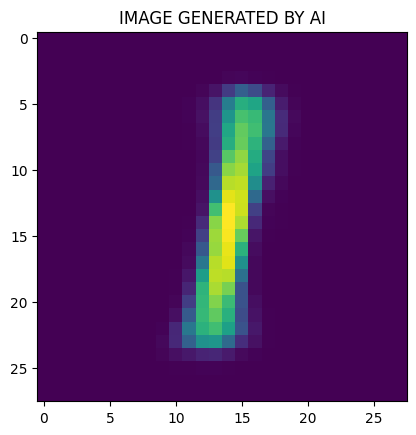

In [104]:
ax = plt.imshow(predict(model,test_sample)[4])
plt.title("IMAGE GENERATED BY AI")
plt.show()

# DISPLAYING 2D MANIFOLDS OF IMAGES

In [108]:
def plot_latent_images(model, n, digit_size=28):
  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))
  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

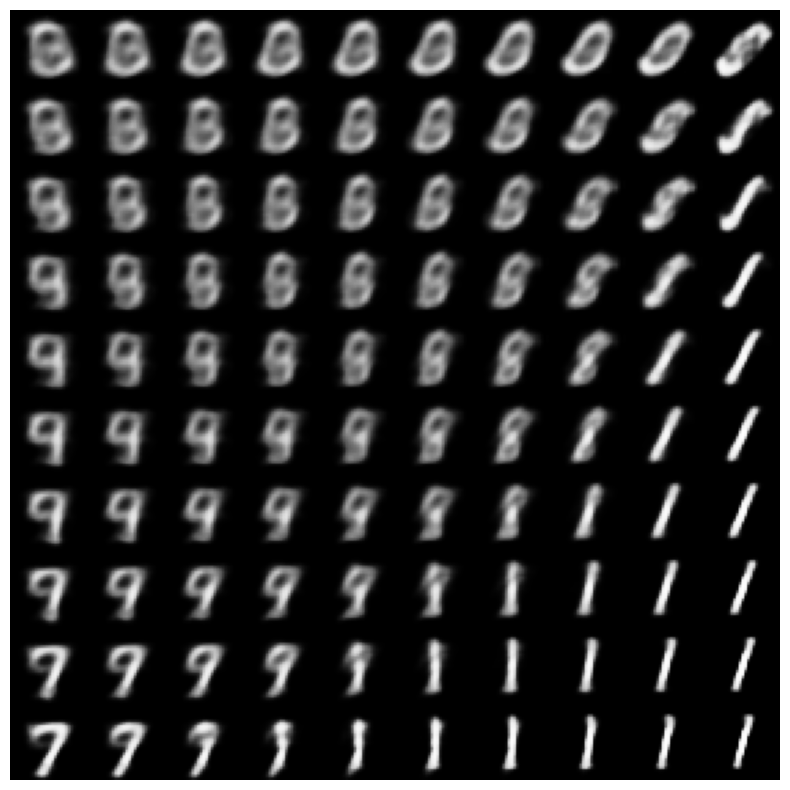

In [109]:
plot_latent_images(model, 10)